In [1]:
import numpy as np
import pandas
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import cv2

In [2]:
TRAIN_DIR = '/Users/songyihe/Documents/Study/AI_Projects/large-datasets/human-face/xy.pkl'

# Explantory Data Analyisis - Take a Glance at the Data

Data Shape

In [3]:
import pickle
from matplotlib import pyplot as plt

In [4]:
with open(TRAIN_DIR, 'rb') as whdl:
    (IM_train,y_train,IM_test) = pickle.load(whdl)

In [5]:
len(IM_train)

58512

In [6]:
IM_train[0].shape

(100, 100, 3)

In [7]:
len(y_train)

58512

In [8]:
IM_test[0].shape

(250, 250, 3)

Observation: IM_train contains 58512 100\*100\*3 pictures. y_train contains 58512 labels. IM_test contains 250\*250\*3 pictures. 

Picture Examples

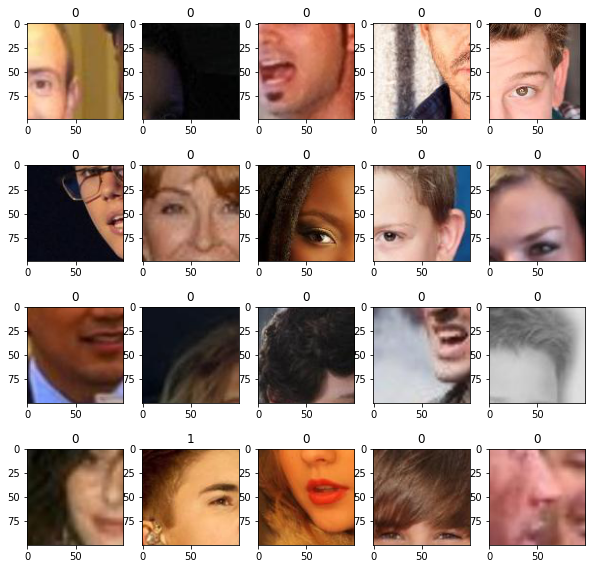

In [9]:
plt.figure(figsize=(10,10))
for i in range(20):
    index = int(np.random.uniform(low=0, high=58511))
    plt.subplot(4,5,i + 1)
    plt.imshow(IM_train[index])
    plt.title(y_train[index])

Observation: The label shows whether it's a human face.

Channel Examples

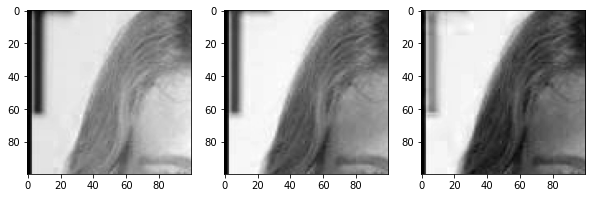

In [10]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i + 1)
    plt.imshow(IM_train[0][:,:,i],cmap='gray')

Observation: All 3 channels can show the shape of the picture.

# Build Histogram Feature

Demo

In [11]:
def demo_histogram(picture, bins=256):
    color = ('b','g','r')
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.imshow(picture)
    plt.subplot(1,2,2)
    for i, col in enumerate(color):
        histr = cv2.calcHist([picture], [i], None, [bins], [0,256])
        plt.plot(histr, color = col)
        plt.xlim([0,bins])

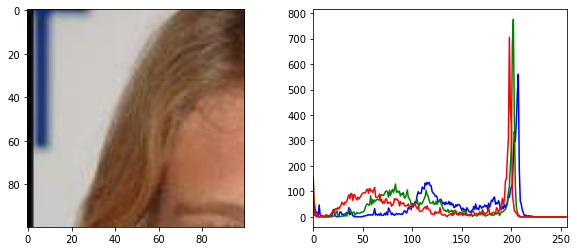

In [12]:
demo_histogram(IM_train[0])

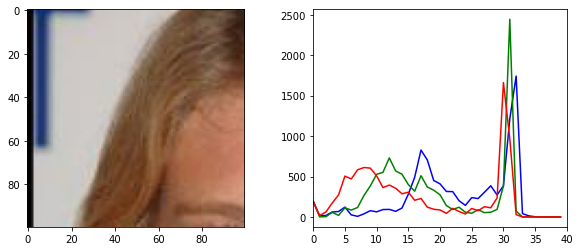

In [13]:
demo_histogram(IM_train[0], bins=40)

Build Feature

In [14]:
def Build_Histogram(IM_train, y_train):
    X, y = [], []
    color = ('b','g','r')
    for image, label in tqdm(zip(IM_train, y_train)):
        if len(image.shape) != 3:
            continue
        
        X_i = []
        for i,col in enumerate(color):
            histr = cv2.calcHist([image], [i], None, [40], [0,256]).T[0]
            X_i.append(histr)
        
        X.append(np.concatenate(X_i))
        y.append(label)
        
    return X, y

In [15]:
X_hist, y_hist = Build_Histogram(IM_train, y_train)

58512it [00:05, 9946.52it/s] 


# Build HOG Feature

In [16]:
def translate(image, x, y):
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted

In [17]:
def calculate_histogram(array,weights,bins=9):
    bins_range = (-75, 75)
    hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)
    return hist

In [18]:
def extract_feature(image, verbose=False):
    image = IM_train[0]

    # Step 1: Gray
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    if verbose:
        fig = plt.figure(figsize=(15, 3))
        plt.subplot(1, 6, 1)
        plt.title('Gray')
        plt.imshow(image, cmap='gray')

    # Step 2: Sqrt
    image = image ** 0.5
    if verbose:
        plt.subplot(1, 6, 2)
        plt.title('Sqrt')
        plt.imshow(image, cmap='gray')

    # Step 3: GX, GY
    GX = translate(image, 1, 0) - translate(image, -1, 0)
    GY = translate(image, 0, 1) - translate(image, 0, -1)
    if verbose:
        plt.subplot(1, 6, 3)
        plt.title('GX')
        plt.imshow(GX, cmap='gray')

    # Step 4: Angle
    delta_G = np.sqrt(GX ** 2 + GY ** 2)
    angle = np.arctan(GY / GX) / np.pi * 180
    if verbose:
        plt.subplot(1, 6, 4)
        plt.title('Angle')
        plt.imshow(angle, cmap='gray')

    # Step 5: Histogram
    features = np.zeros((4,4,9))
    for i in range(0, 100, 25):
        for j in range(0, 100, 25):
            features[i // 25,j // 25] = calculate_histogram(angle[i:i + 25,j:j + 25],
                                                            delta_G[i:i + 25,j:j + 25])
    if verbose:
        plt.subplot(1, 6, 5)
        plt.imshow(features.reshape(4,36))

    # Step 6: Local Normalize
    one_feature = []
    for i in range(3):
        for j in range(3):
            mat_norm = features[i:i + 2,j:j + 2]
            mag = np.linalg.norm(mat_norm)
            arr_list = (mat_norm / mag).flatten().tolist()
            one_feature += arr_list
    if verbose:
        plt.subplot(1, 6, 6) 
        plt.imshow(np.asarray(one_feature).reshape(9,-1))
    
    return one_feature

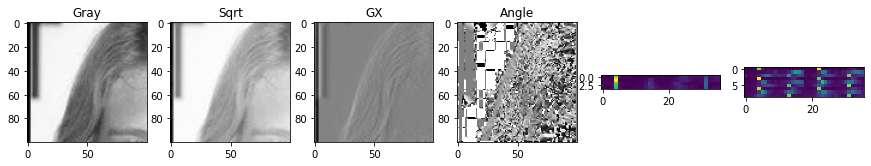

In [19]:
feature = extract_feature(IM_train[0], verbose=True)

In [20]:
def Build_HOG(IM_train, y_train):
    X, y = [], []
    color = ('b','g','r')
    for image, label in tqdm(zip(IM_train, y_train)):
        if len(image.shape) != 3:
            continue
        
        X.append(extract_feature(image))
        y.append(label)
        
    return X, y

In [21]:
X_hog, y_hog = Build_HOG(IM_train, y_train)

58512it [05:10, 188.18it/s]


# Models

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
cross_val_score(lr, X_hist, y_hist, cv=5)

array([0.95083512, 0.95048826, 0.95237279, 0.95074525, 0.95185883])

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
cross_val_score(lr, X_hog, y_hog, cv=5)

array([0.95280514, 0.95288676, 0.95288676, 0.95288676, 0.95288676])